# Import packages

In [641]:
import numpy as np
import pandas as pd
import keras
import tensorflow
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm
from sklearn import preprocessing 
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv1D, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from keras import optimizers
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler,TomekLinks

# Import data

In [252]:
data = pd.read_csv('data/creditcard.csv')
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

In [246]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [247]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

# Preparation

In [590]:
nf = data[data['Class'] == 0].sample(492*9)
f = data[data['Class'] == 1]
df = nf.append(f).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

scalar = StandardScaler()
x_train_scale = scalar.fit_transform(X_train)
x_test_scale = scalar.transform(X_test)

x_norm_test, x_fraud_test = x_test_scale[y_test == 0], x_test_scale[y_test == 1]

def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], color='b', linewidth=0.5, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], color='r', linewidth=0.5, alpha=0.8, label='Fraud')
    plt.legend(loc='best');
    plt.show();

In [483]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [189]:
def undersampling_data_prep(method):   
    if(method == "cc"):
        undersample = ClusterCentroids(random_state=0)
    elif(method == "tomek"):
        undersample = TomekLinks()
    elif(method == 'random'):
        undersample = RandomUnderSampler(random_state=0)
    
    a,b = undersample.fit_resample(X_train, y_train)
    print(len(a))
    
    return a,b

In [190]:
def oversampling_data_prep(method):
    if(method == "smote"):
        oversample = SMOTE()
    elif(method == "adasyn"):
        oversample = ADASYN()
    elif(method == 'random'):
        oversample = RandomOverSampler(random_state=0)
        
    c,d = oversample.fit_resample(X_train, y_train)
    print(len(c))
    
    return c,d

# TSNE plot before training

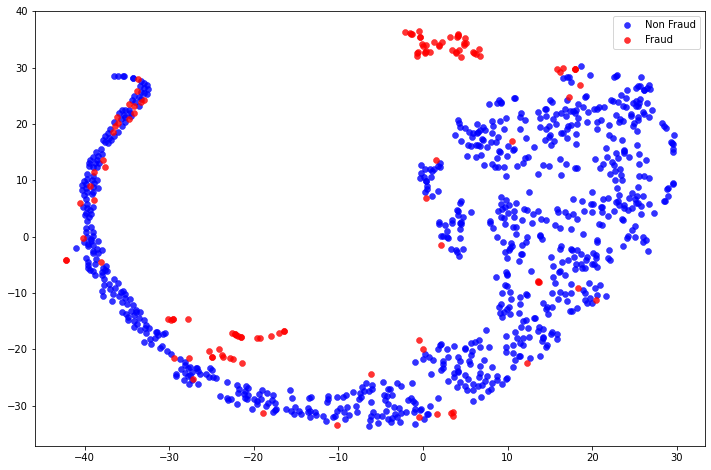

In [507]:
tsne_plot(X_test,y_test)

# AutoEncoder

In [739]:
def AE():
    input_layer = Input(shape=(X_train.shape[1],))
    encoded = Dense(64, activation='tanh', 
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(32, activation='relu')(encoded)

    decoded = Dense(32, activation='tanh')(encoded)

    output_layer = Dense(X.shape[1], activation='relu')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer = optimizers.Adam(learning_rate = 0.01), 
                        loss = 'mse', metrics = ['accuracy', recall_m, precision_m])

    return autoencoder

def run_autoencoder():
    autoencoder = AE()
    history = autoencoder.fit(X_train, X_train, validation_data = (X_test, X_test), batch_size = 128, epochs = 100, shuffle = True, verbose = 0);
    hr = Sequential()
    hr.add(autoencoder.layers[0])
    hr.add(autoencoder.layers[1])
    hr.add(autoencoder.layers[2])
    norm_hid_rep = hr.predict(x_norm_test[:2000])
    fraud_hid_rep = hr.predict(x_fraud_test)
    rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
    y_n = np.zeros(norm_hid_rep.shape[0])
    y_f = np.ones(fraud_hid_rep.shape[0])
    rep_y = np.append(y_n, y_f)
    tsne_plot(rep_x, rep_y)
    score = autoencoder.evaluate(X_test, X_test)
    print("Classification report: ")
    print("Accuracy: %.2f" % score[1]) 
    print("Precision: %.2f " % score[2])
    print("Recall: %.2f" % score[3])
    return score[1:], history

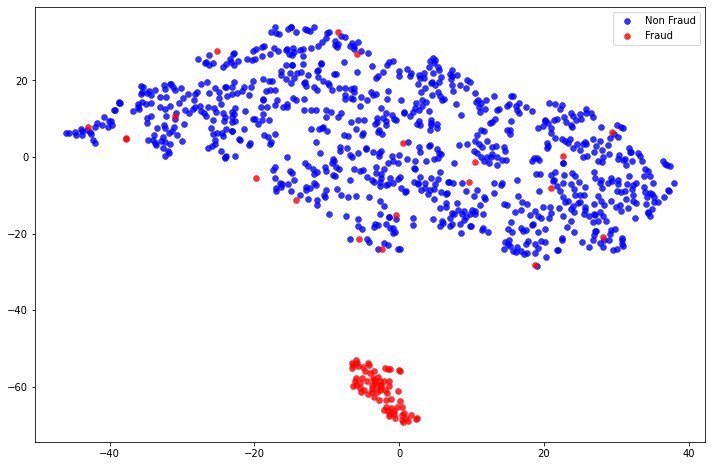

31/31 [==============================] - 0s 894us/step - loss: 1412.0773 - accuracy: 0.9106 - recall_m: 0.2349 - precision_m: 0.9140
Classification report: 
Accuracy: 0.91
Precision: 0.23 
Recall: 0.91


In [595]:
autoencoder = run_autoencoder()

# ANN

In [560]:
metrics = [
    'accuracy',
    keras.metrics.Precision(),
    keras.metrics.Recall()
]

def NN(Xt):
    model = keras.Sequential()
    model.add(Dense(64, activation='relu', input_shape=(Xt.shape[-1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer = optimizers.Adam(learning_rate = 0.01), 
                  loss = 'binary_crossentropy', metrics = metrics)
    
    return model

def O_Run(m):
    Xtrain, ytrain = oversampling_data_prep(m)
    model = NN(Xt = X_train)
    history = model.fit(Xtrain, ytrain, validation_data = (X_test, y_test), batch_size = 128, epochs = 100, verbose = 0)
    norm_hid_rep = model.predict(x_norm_test[:2000])
    fraud_hid_rep = model.predict(x_fraud_test)
    rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
    y_n = np.zeros(norm_hid_rep.shape[0])
    y_f = np.ones(fraud_hid_rep.shape[0])
    rep_y = np.append(y_n, y_f)
    tsne_plot(rep_x, rep_y)
    score = model.evaluate(X_test, y_test)
    print("Classification report: ")
    print("Accuracy: %.2f" % score[1]) 
    print("Precision: %.2f " % score[2])
    print("Recall: %.2f" % score[3])
    return score[1:], history

def U_Run(m):
    Xtrain, ytrain = undersampling_data_prep(m)
    model = NN(Xt = X_train)
    history = model.fit(Xtrain, ytrain, validation_data = (X_test, y_test), batch_size = 128, epochs = 100, verbose = 0)
    norm_hid_rep = model.predict(x_norm_test[:2000])
    fraud_hid_rep = model.predict(x_fraud_test)
    rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
    y_n = np.zeros(norm_hid_rep.shape[0])
    y_f = np.ones(fraud_hid_rep.shape[0])
    rep_y = np.append(y_n, y_f)
    tsne_plot(rep_x, rep_y)
    score = model.evaluate(X_test, y_test)
    print("Classification report: ")
    print("Accuracy: %.2f" % score[1]) 
    print("Precision: %.2f " % score[2])
    print("Recall: %.2f" % score[3])
    return score[1:], history

# Oversampling: Random, SMOTE, ADASYN

7090


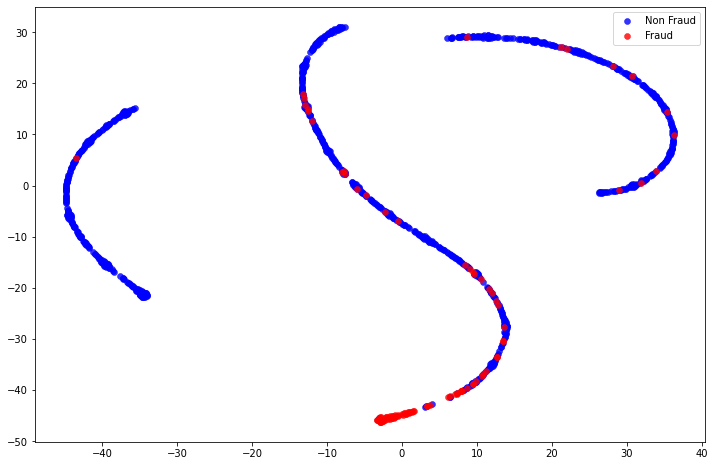

31/31 [==============================] - 0s 2ms/step - loss: 0.1004 - accuracy: 0.9776 - precision_36: 0.8835 - recall_35: 0.9010
Classification report: 
Accuracy: 0.98
Precision: 0.88 
Recall: 0.90


In [577]:
Over_random = O_Run("random")

7072


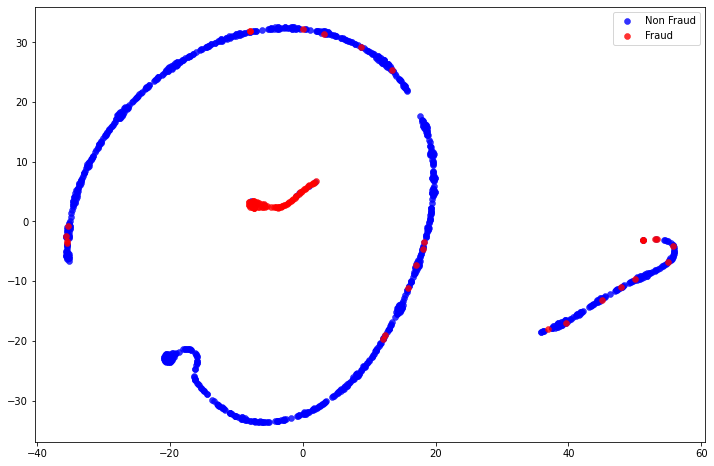

31/31 [==============================] - 0s 849us/step - loss: 0.0992 - accuracy: 0.9766 - precision_36: 0.8791 - recall_35: 0.8696
Classification report: 
Accuracy: 0.98
Precision: 0.88 
Recall: 0.87


In [562]:
smote = O_Run("smote")

7070


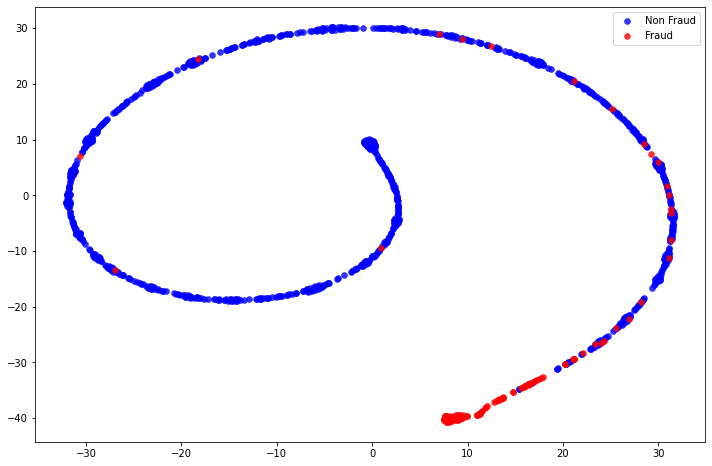

31/31 [==============================] - 0s 841us/step - loss: 0.1228 - accuracy: 0.9634 - precision_36: 0.7731 - recall_35: 0.9109
Classification report: 
Accuracy: 0.96
Precision: 0.77 
Recall: 0.91


In [578]:
adasyn = O_Run("adasyn")

# Undersampling: Random, TomekLinks, ClusterCentroids

782


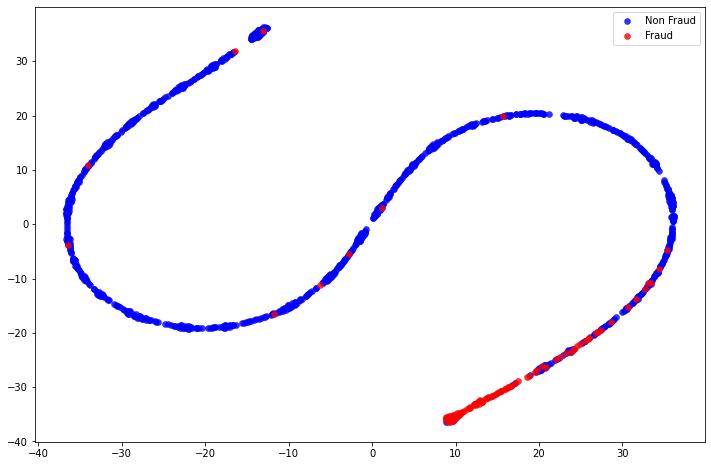

31/31 [==============================] - 0s 1ms/step - loss: 0.1129 - accuracy: 0.9563 - precision_36: 0.7377 - recall_35: 0.8911
Classification report: 
Accuracy: 0.96
Precision: 0.74 
Recall: 0.89


In [579]:
Under_random = U_Run("random")

782


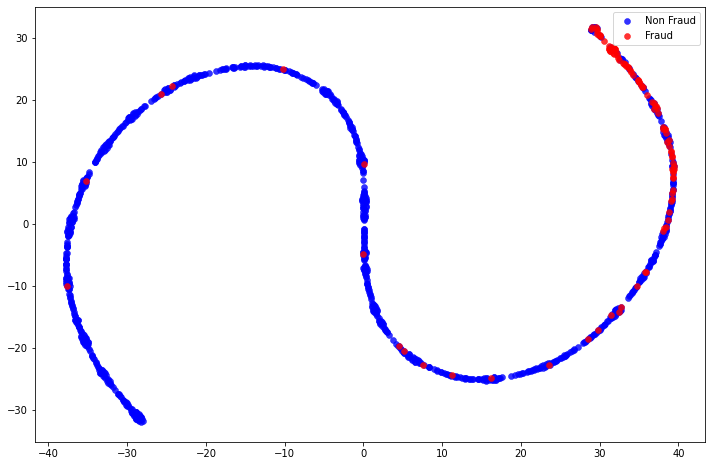

31/31 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9329 - precision_36: 0.6224 - recall_35: 0.8812
Classification report: 
Accuracy: 0.93
Precision: 0.62 
Recall: 0.88


In [583]:
cc = U_Run("cc")

3915


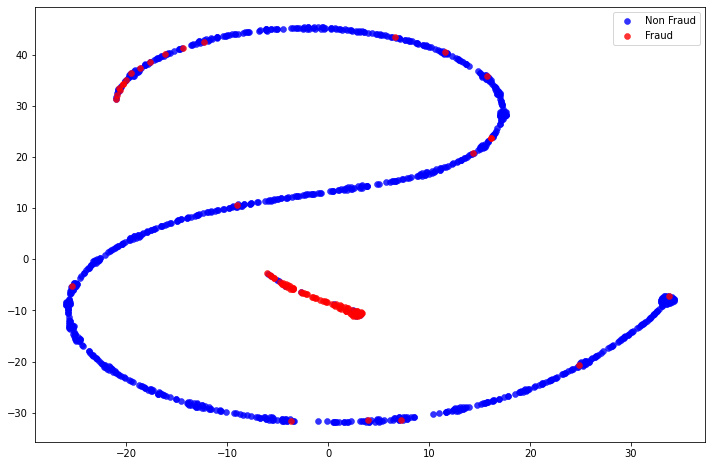

31/31 [==============================] - 0s 1ms/step - loss: 0.0745 - accuracy: 0.9848 - precision_36: 0.9639 - recall_35: 0.8696
Classification report: 
Accuracy: 0.98
Precision: 0.96 
Recall: 0.87


In [567]:
Tomek = U_Run("tomek")

# CNN

In [726]:
nf = data[data['Class'] == 0].sample(492*9)
f = data[data['Class'] == 1]
df = nf.append(f).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

scalar = StandardScaler()
x_train_scale = scalar.fit_transform(X_train)
x_test_scale_CNN = scalar.transform(X_test).reshape(X_test.shape[0],X_test.shape[1],1)

x_norm_test_CNN, x_fraud_test_CNN = x_test_scale_CNN[y_test == 0], x_test_scale_CNN[y_test == 1]

def CNN(Xt):
    model=Sequential()
    model.add(Conv1D(64,2,activation = 'relu',input_shape=Xt[0].shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv1D(32,2,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(32,activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1,activation = 'sigmoid'))
    
    model.compile(optimizer = optimizers.Adam(learning_rate = 0.01), 
                  loss='binary_crossentropy', metrics = metrics)
    
    return model

def CNN_O_run(m):
    Xtrain, ytrain = oversampling_data_prep(m)
    Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
    X_t = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
    model = CNN(Xt = Xtrain)
    history = model.fit(Xtrain, ytrain, validation_data = (X_t, y_test), batch_size = 128, epochs = 100, verbose = 0)
    norm_hid_rep = model.predict(x_norm_test_CNN[:2000])
    fraud_hid_rep = model.predict(x_fraud_test_CNN)
    rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
    y_n = np.zeros(norm_hid_rep.shape[0])
    y_f = np.ones(fraud_hid_rep.shape[0])
    rep_y = np.append(y_n, y_f)
    tsne_plot(rep_x, rep_y)
    score = model.evaluate(X_t, y_test)
    print("Classification report: ")
    print("Accuracy: %.2f" % score[1]) 
    print("Precision: %.2f " % score[2])
    print("Recall: %.2f" % score[3])
    return score[1:], history

def CNN_U_run(m):
    Xtrain, ytrain = undersampling_data_prep(m)
    Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
    X_t = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
    model = CNN(Xt = Xtrain)
    history = model.fit(Xtrain, ytrain, validation_data = (X_t, y_test), batch_size = 128, epochs = 100, verbose = 0)
    norm_hid_rep = model.predict(x_norm_test_CNN[:2000])
    fraud_hid_rep = model.predict(x_fraud_test_CNN)
    rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
    y_n = np.zeros(norm_hid_rep.shape[0])
    y_f = np.ones(fraud_hid_rep.shape[0])
    rep_y = np.append(y_n, y_f)
    tsne_plot(rep_x, rep_y)
    score = model.evaluate(X_t, y_test)
    print("Classification report: ")
    print("Accuracy: %.2f" % score[1]) 
    print("Precision: %.2f " % score[2])
    print("Recall: %.2f" % score[3])
    return score[1:], history

7072


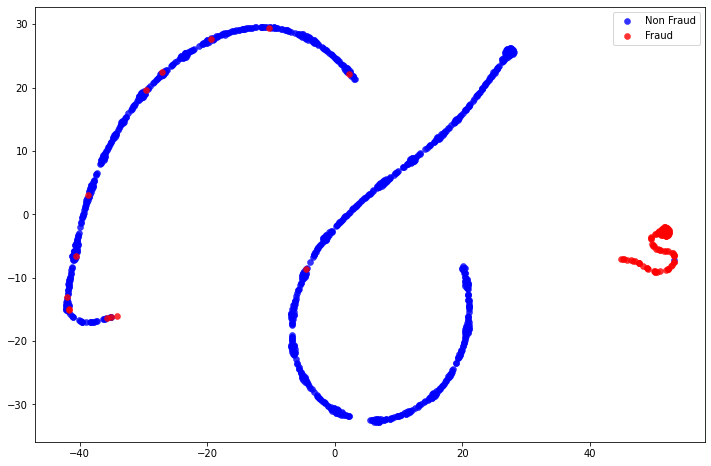

31/31 [==============================] - 0s 1ms/step - loss: 0.0893 - accuracy: 0.9807 - precision_35: 0.9101 - recall_34: 0.8804
Classification report: 
Accuracy: 0.98
Precision: 0.91 
Recall: 0.88


In [554]:
Over_random_CNN = CNN_O_run("random")

7072


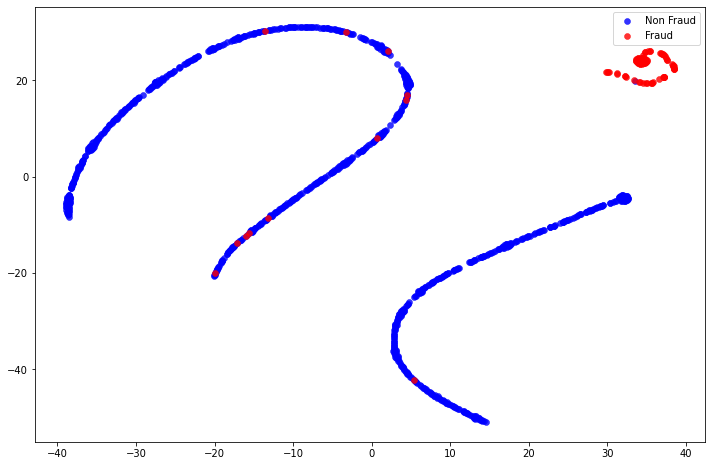

31/31 [==============================] - 0s 1ms/step - loss: 0.0968 - accuracy: 0.9776 - precision_35: 0.8889 - recall_34: 0.8696
Classification report: 
Accuracy: 0.98
Precision: 0.89 
Recall: 0.87


In [555]:
smote_CNN = CNN_O_run("random")

7090


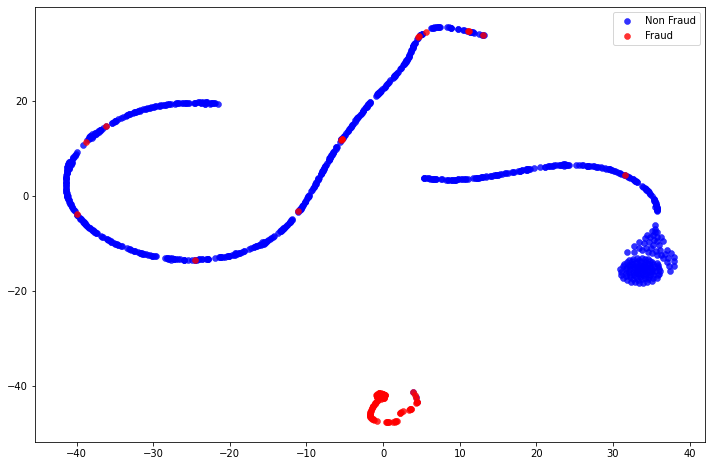

31/31 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.9746 - precision_35: 0.8602 - recall_34: 0.8696
Classification report: 
Accuracy: 0.97
Precision: 0.86 
Recall: 0.87


In [556]:
adasyn_CNN = CNN_O_run("adasyn")

800


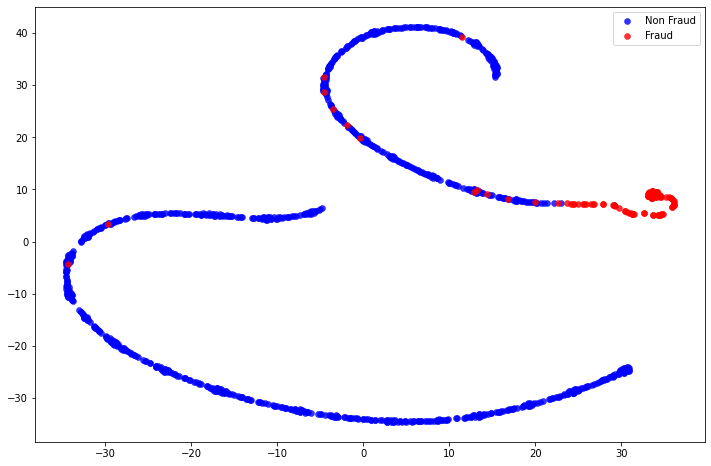

31/31 [==============================] - 0s 2ms/step - loss: 0.1000 - accuracy: 0.9695 - precision_35: 0.7925 - recall_34: 0.9130
Classification report: 
Accuracy: 0.97
Precision: 0.79 
Recall: 0.91


In [557]:
Under_random_CNN = CNN_U_run("random")

800


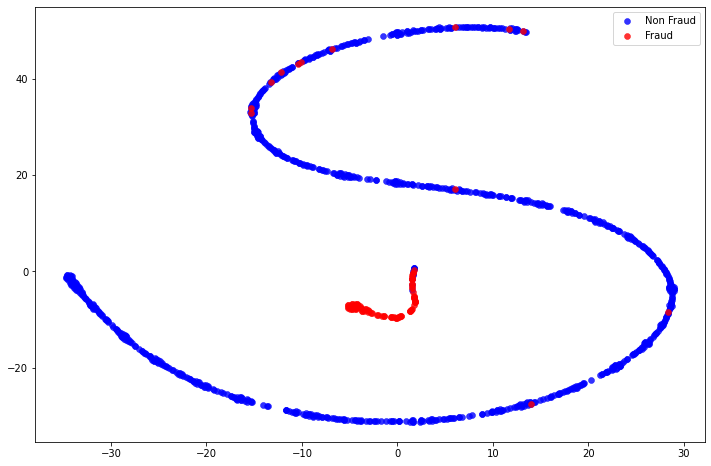

31/31 [==============================] - 0s 1ms/step - loss: 0.3138 - accuracy: 0.8211 - precision_35: 0.3359 - recall_34: 0.9348
Classification report: 
Accuracy: 0.82
Precision: 0.34 
Recall: 0.93


In [558]:
cc_CNN = CNN_U_run("cc")

3915


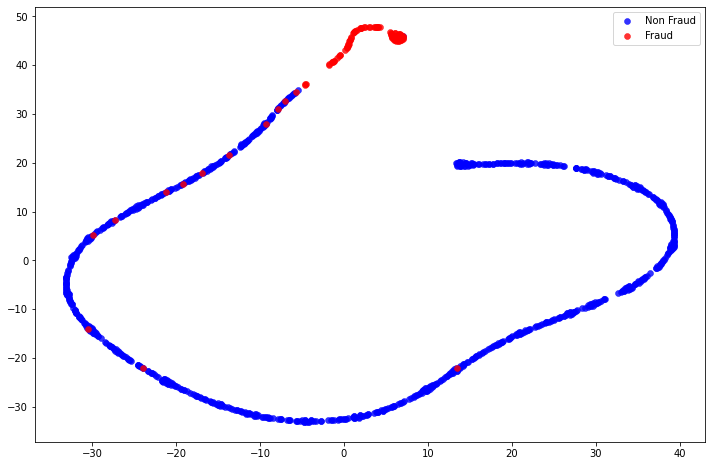

31/31 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9848 - precision_35: 0.9753 - recall_34: 0.8587
Classification report: 
Accuracy: 0.98
Precision: 0.98 
Recall: 0.86


In [559]:
Tomek_CNN = CNN_U_run("tomek")

# Evaluation

In [596]:
print("Autoencoder:")
print(autoencoder)
print()
print("ANN:")
print("Oversampling_random")
print(Over_random)
print("Smote")
print(smote)
print("Adasyn")
print(adasyn)
print("Undersampling_random")
print(Under_random)
print("ClusterCentroids")
print(cc)
print("TomekLinks")
print(Tomek)
print()
print("CNN:")
print("Oversampling_random")
print(Over_random_CNN)
print("Smote")
print(smote_CNN)
print("Adasyn")
print(adasyn_CNN)
print("Undersampling_random")
print(Under_random_CNN)
print("ClusterCentroids")
print(cc_CNN)
print("TomekLinks")
print(Tomek_CNN)

Autoencoder:
([0.9105691313743591, 0.23489786684513092, 0.9140002727508545], <keras.callbacks.History object at 0x1641d2668>)

ANN:
Oversampling_random
([0.977642297744751, 0.8834951519966125, 0.9009901285171509], <keras.callbacks.History object at 0x1660a5dd8>)
Smote
([0.9766260385513306, 0.8791208863258362, 0.8695651888847351], <keras.callbacks.History object at 0x185321cf8>)
Adasyn
([0.9634146094322205, 0.7731092572212219, 0.9108911156654358], <keras.callbacks.History object at 0x1718c3400>)
Undersampling_random
([0.9563007950782776, 0.7377049326896667, 0.8910890817642212], <keras.callbacks.History object at 0x15b851470>)
ClusterCentroids
([0.9329268336296082, 0.6223776340484619, 0.8811880946159363], <keras.callbacks.History object at 0x17442c978>)
TomekLinks
([0.9847561120986938, 0.9638554453849792, 0.8695651888847351], <keras.callbacks.History object at 0x169950c50>)

CNN:
Oversampling_random
([0.9806910753250122, 0.9101123809814453, 0.8804348111152649], <keras.callbacks.History o

In [684]:
ls = [autoencoder, Over_random, smote, adasyn, Under_random, cc, Tomek, 
      Over_random_CNN, smote_CNN, adasyn_CNN, Under_random_CNN, cc_CNN, Tomek_CNN]
l = np.arange(len(ls))
methods = ["autoencoder", "Over_random", "smote", "adasyn", "Under_random", "cc", "Tomek", 
      "Over_random_CNN", "smote_CNN", "adasyn_CNN", "Under_random_CNN", "cc_CNN", "Tomek_CNN"]
Pre = []
Acc = []
Rec = []
Loss = []
for i in ls:
    Acc.append(i[0][0])
    Pre.append(i[0][1])
    Rec.append(i[0][2])   
    Loss.append(np.mean(i[1].history['loss']))
    
ANN = [Over_random, smote, adasyn, Under_random, cc, Tomek]
ANN_methods = ["Over_random", "smote", "adasyn", "Under_random", "cc", "Tomek"]
lANN = np.arange(len(ANN))

PreANN = []
AccANN = []
RecANN = []
LossANN = []
for i in ANN:
    AccANN.append(i[0][0])
    PreANN.append(i[0][1])
    RecANN.append(i[0][2])   
    LossANN.append(np.mean(i[1].history['loss']))
    
CNN = [Over_random_CNN, smote_CNN, adasyn_CNN, Under_random_CNN, cc_CNN, Tomek_CNN]
CNN_methods = ["Over_random_CNN", "smote_CNN", "adasyn_CNN", "Under_random_CNN", "cc_CNN", "Tomek_CNN"]
lCNN = np.arange(len(CNN))

PreCNN = []
AccCNN = []
RecCNN = []
LossCNN = []
for i in CNN:
    AccCNN.append(i[0][0])
    PreCNN.append(i[0][1])
    RecCNN.append(i[0][2])   
    LossCNN.append(np.mean(i[1].history['loss']))

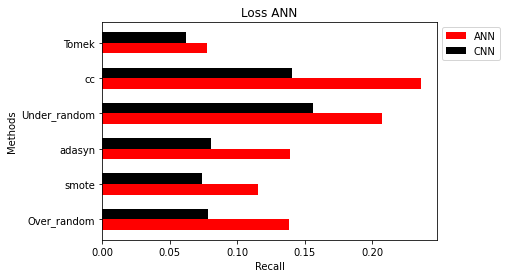

In [733]:
plt.barh(lANN, LossANN, width, color = "red", label = "ANN")
plt.barh(lCNN + width, LossCNN, width, color = "black", label = "CNN")
plt.yticks(lANN + width / 2, ANN_methods)
plt.xlabel('Recall')
plt.ylabel('Methods')
plt.title('Loss ANN')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

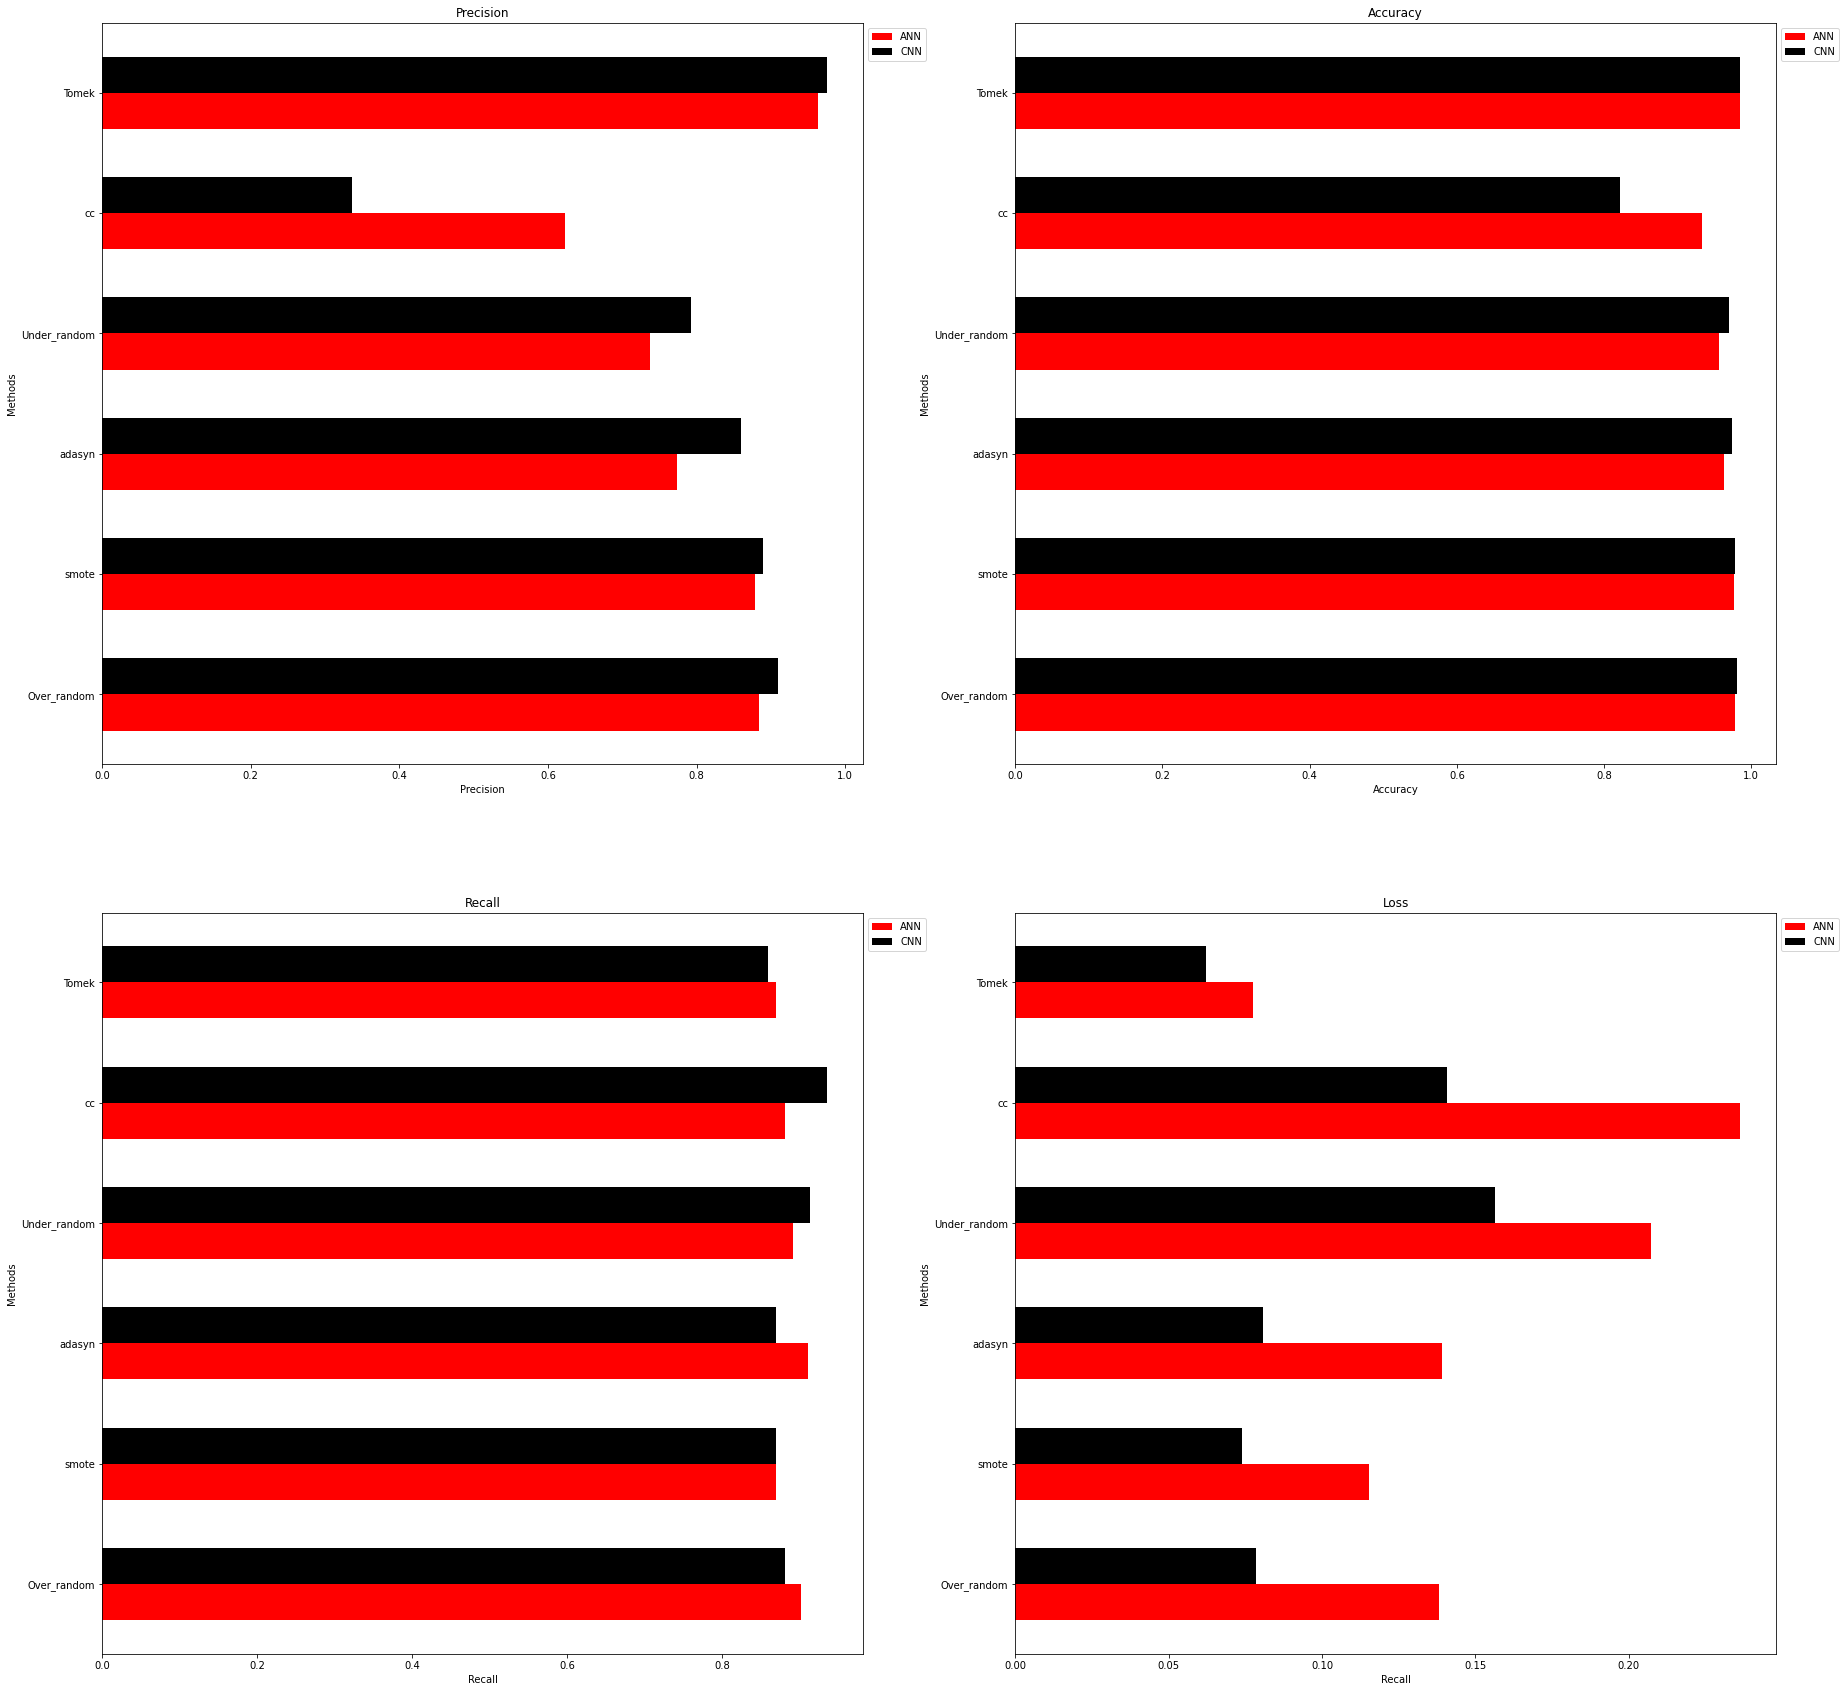

In [734]:
width = 0.3
f, axs = plt.subplots(2,2,figsize=(30,30))
plt.subplot(2, 2, 1)
plt.barh(lANN, PreANN, width, color = "red", label = "ANN")
plt.barh(lCNN + width, PreCNN, width, color = "black", label = "CNN")
plt.yticks(lANN + width / 2, ANN_methods)
plt.xlabel('Precision')
plt.ylabel('Methods')
plt.title('Precision')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.subplot(2, 2, 2)
plt.barh(lANN, AccANN, width, color = "red", label = "ANN")
plt.barh(lCNN + width, AccCNN, width, color = "black", label = "CNN")
plt.yticks(lANN + width / 2, ANN_methods)
plt.xlabel('Accuracy')
plt.ylabel('Methods')
plt.title('Accuracy')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.subplot(2, 2, 3)
plt.barh(lANN, RecANN, width, color = "red", label = "ANN")
plt.barh(lCNN + width, RecCNN, width, color = "black", label = "CNN")
plt.yticks(lANN + width / 2, ANN_methods)
plt.xlabel('Recall')
plt.ylabel('Methods')
plt.title('Recall')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.subplot(2, 2, 4)
plt.barh(lANN, LossANN, width, color = "red", label = "ANN")
plt.barh(lCNN + width, LossCNN, width, color = "black", label = "CNN")
plt.yticks(lANN + width / 2, ANN_methods)
plt.xlabel('Recall')
plt.ylabel('Methods')
plt.title('Loss')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

Text(0.5, 1.0, 'Loss Comparison')

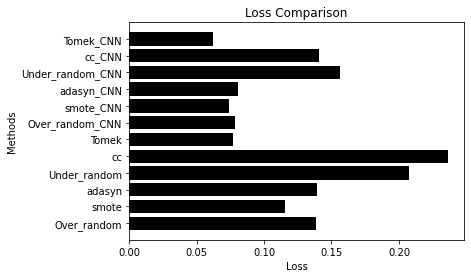

In [738]:
plt.barh(x, Loss[1:], color = "black")
plt.yticks(x, methods[1:])
plt.xlabel('Loss')
plt.ylabel('Methods')
plt.title('Loss Comparison')

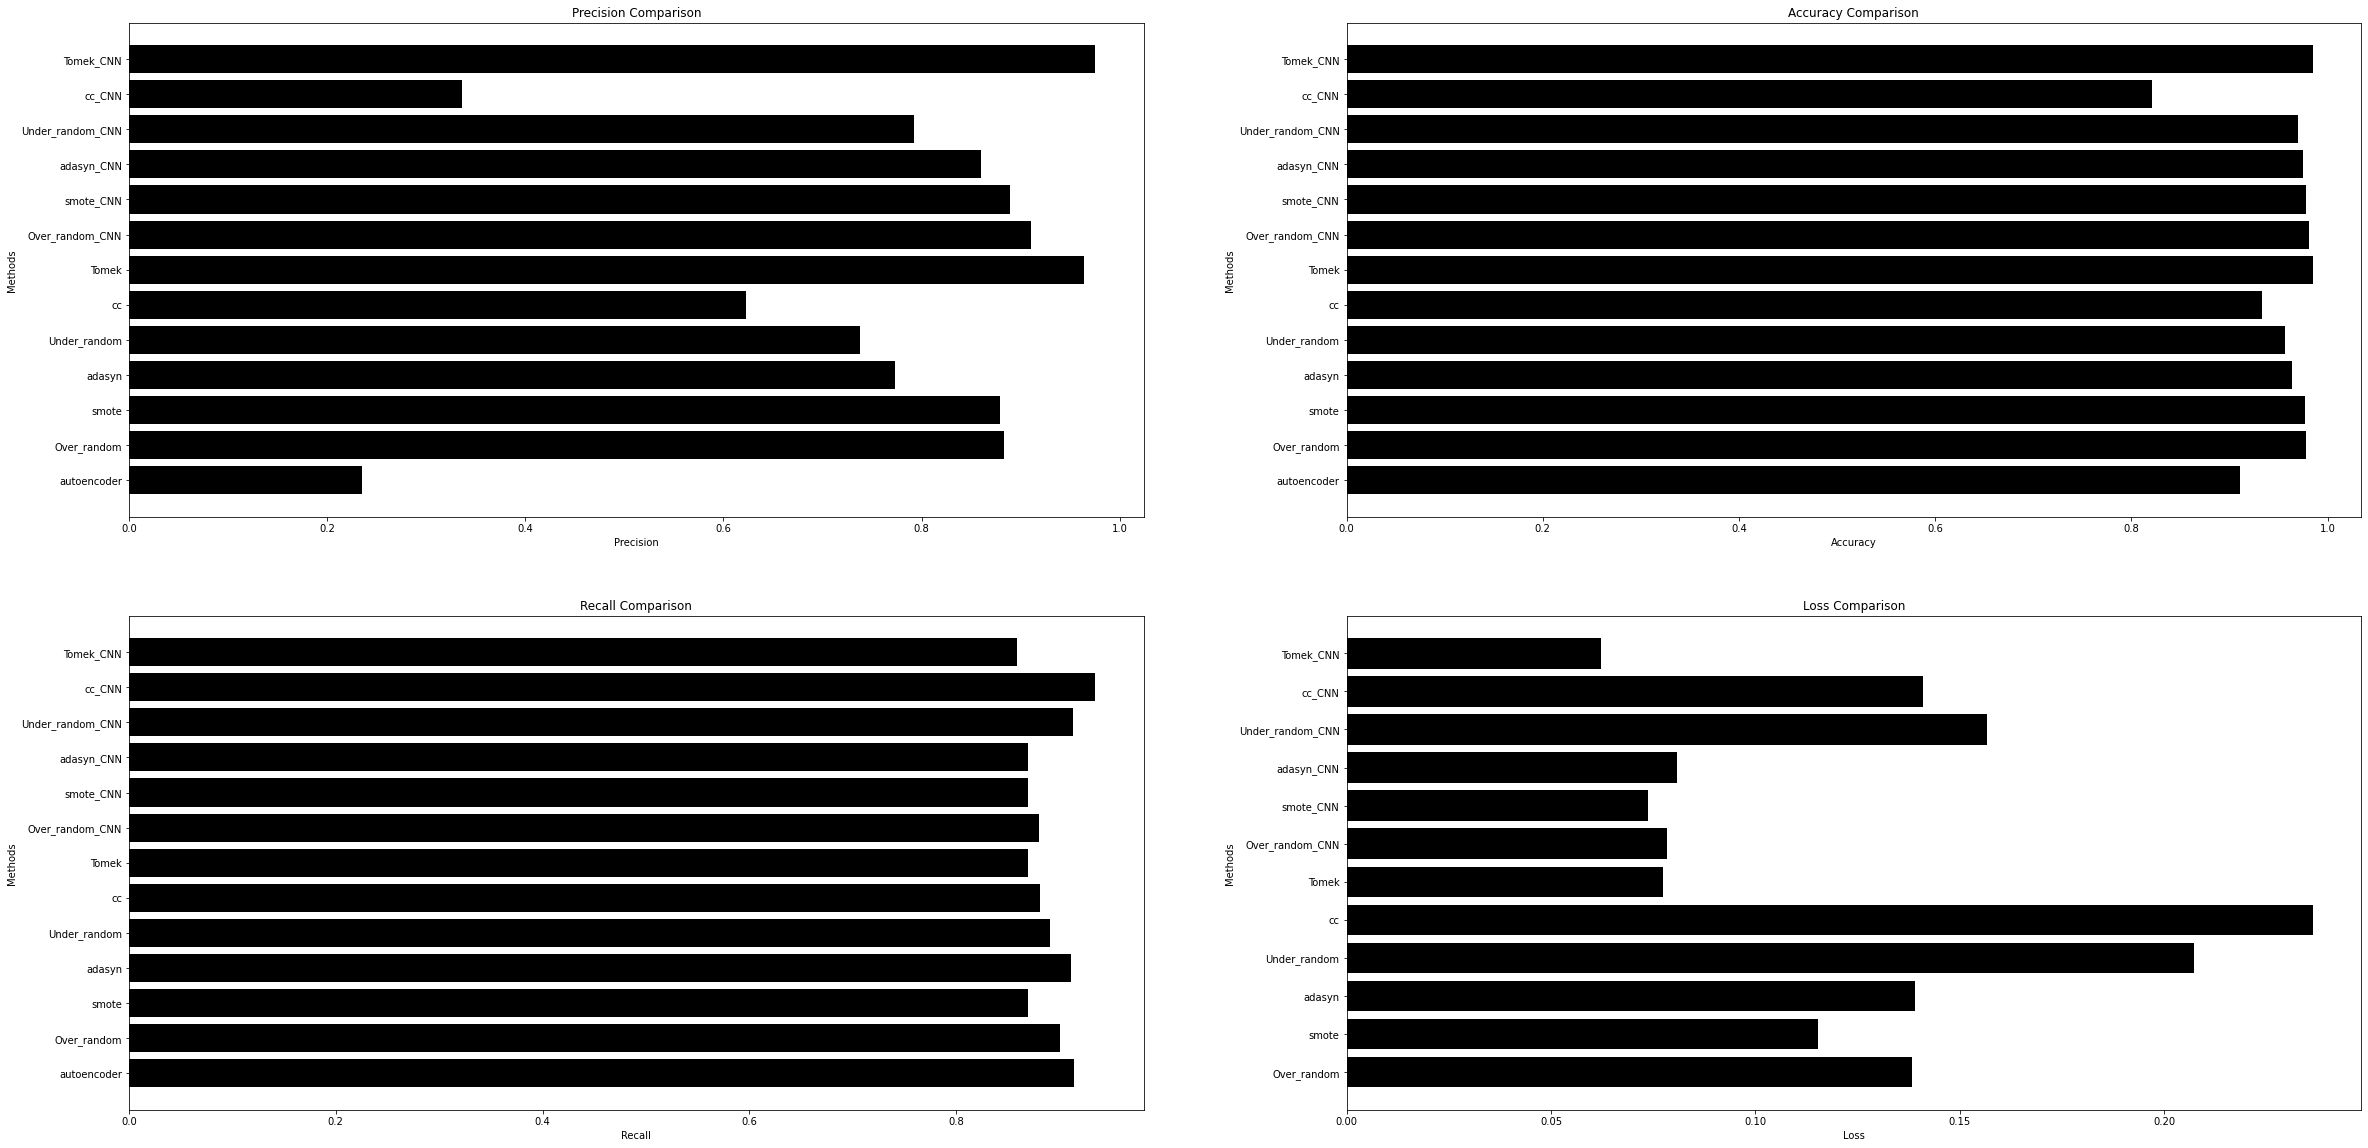

In [729]:
f, axs = plt.subplots(2,2,figsize=(40,20))
plt.subplot(2, 2, 1)
plt.barh(l, Pre, color = "black")
plt.yticks(l, methods)
plt.xlabel('Precision')
plt.ylabel('Methods')
plt.title('Precision Comparison')
plt.subplot(2, 2, 2)
cmap = cm.jet(np.linspace(0, 1, len(l)))
plt.barh(l, Acc, color = "black")
plt.yticks(l, methods)
plt.xlabel('Accuracy')
plt.ylabel('Methods')
plt.title('Accuracy Comparison')
plt.subplot(2, 2, 3)
cmap = cm.jet(np.linspace(0, 1, len(l)))
plt.barh(l, Rec, color = "black")
plt.yticks(l, methods)
plt.xlabel('Recall')
plt.ylabel('Methods')
plt.title('Recall Comparison')
plt.subplot(2, 2, 4)
x = np.arange(len(ls)-1)
cmap = cm.jet(np.linspace(0, 1, len(x)))
plt.barh(x, Loss[1:], color = "black")
plt.yticks(x, methods[1:])
plt.xlabel('Loss')
plt.ylabel('Methods')
plt.title('Loss Comparison')
plt.show()